In [10]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
import glob
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib

from GPy.mappings.constant import Constant
from GPy.kern import Matern52
from GPy.models import GPRegression

In [11]:
# Set potting style
plt.style.use('seaborn-white')
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# Define the function to be plotted and create the visualizations
def f(x):
    """The function to predict."""
    return 2*((x-3)*np.sin((x-3))) + 2 + 0.5*x

x_base = np.linspace(0, 6, 1000)

# Gaussian Process without any beliefs

It usually starts with mean zero.

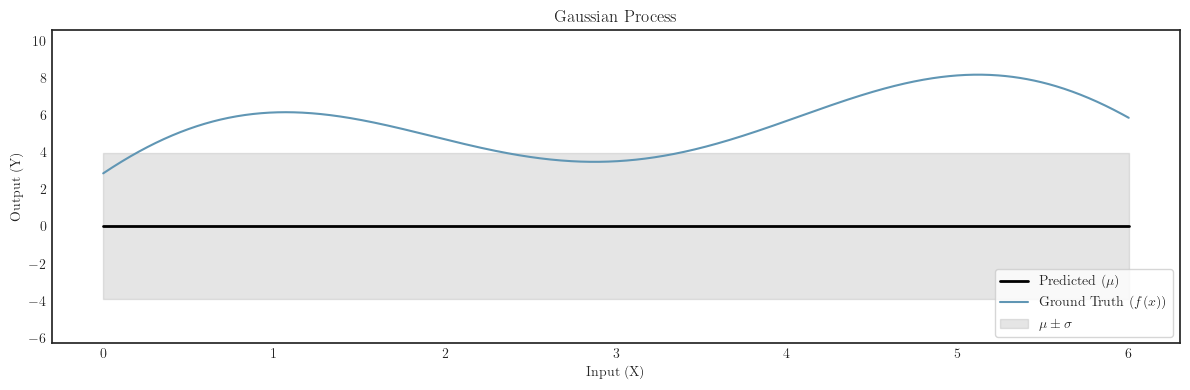

In [12]:

# Make predictions on a grid of points for plotting
X_pred = np.linspace(0, 6, 100).reshape(-1, 1)
Y_pred = np.zeros_like(X_pred)

std_deviation = 1.96  # 95% confidence interval
Y_var = np.ones_like(X_pred) * std_deviation**2  # variance
Y_std = np.sqrt(Y_var)  # standard deviation

# Plot the results
fig = plt.figure(figsize=(12, 4))
plt.plot(X_pred, Y_pred, 'k-', lw=2, label=r'Predicted ($\mu$)')
plt.fill_between(X_pred.flatten(), (Y_pred - 2*Y_std).flatten(), (Y_pred + 2*Y_std).flatten(), color='gray', alpha=0.2, label=r'$\mu \pm \sigma$')
plt.plot(x_base, f(x_base), color="#6096B4", label=r'Ground Truth ($f(x)$)')
plt.legend(loc="lower right", fontsize=10, frameon=True, facecolor='white')
plt.title('Gaussian Process')
plt.xlabel('Input (X)')
plt.ylabel('Output (Y)')
plt.tight_layout()
plt.margins(y=0.2)

# Save the figure to a PDF (enable if needed)
# pdf_file_path = 'gp_0.pdf'  # Change to your preferred file path
# with PdfPages(pdf_file_path) as pdf:
#     pdf.savefig(fig)
# plt.close()

# Show the plot
plt.show()


# Gaussian Process update

The Bayesian Optimization happens sequentially, where each new observation incrementally refines the model.

After observing some data, the GP updates its predictions and uncertainty estimates. The optimization happens iteratively, selecting the most promising point for observations based on the acquisition function, converging the model towards the true objective function.

This can be seen in the sequence of these images, where after each iteration the mean is better defined and reduces the uncertainty.

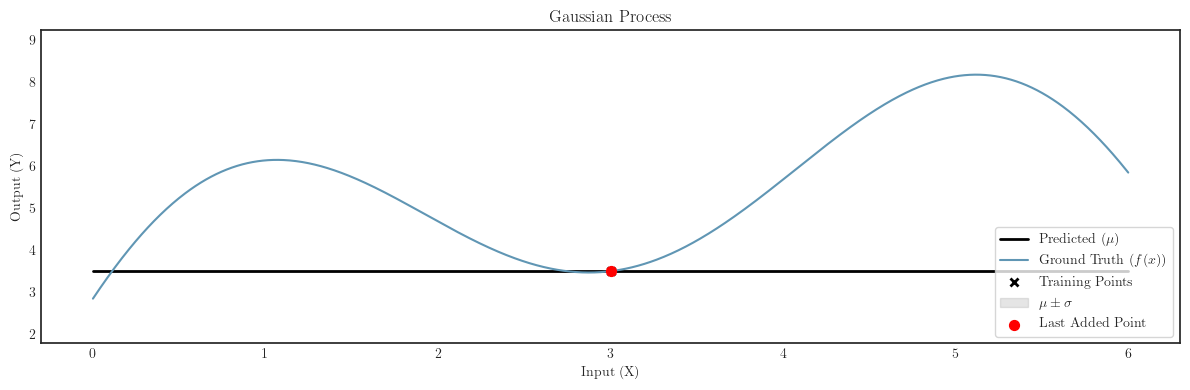

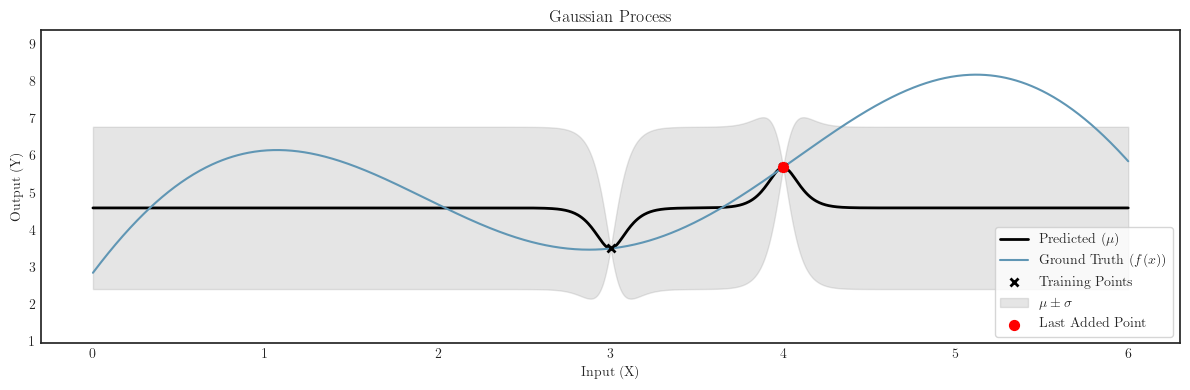

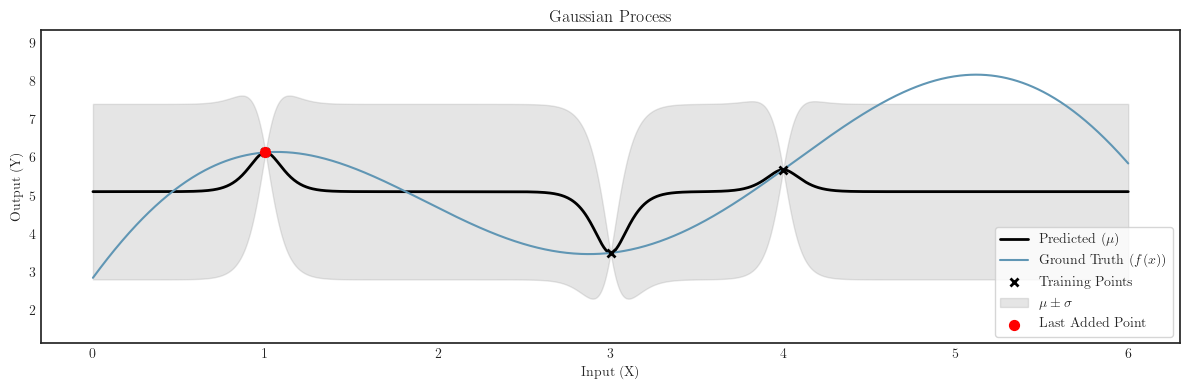

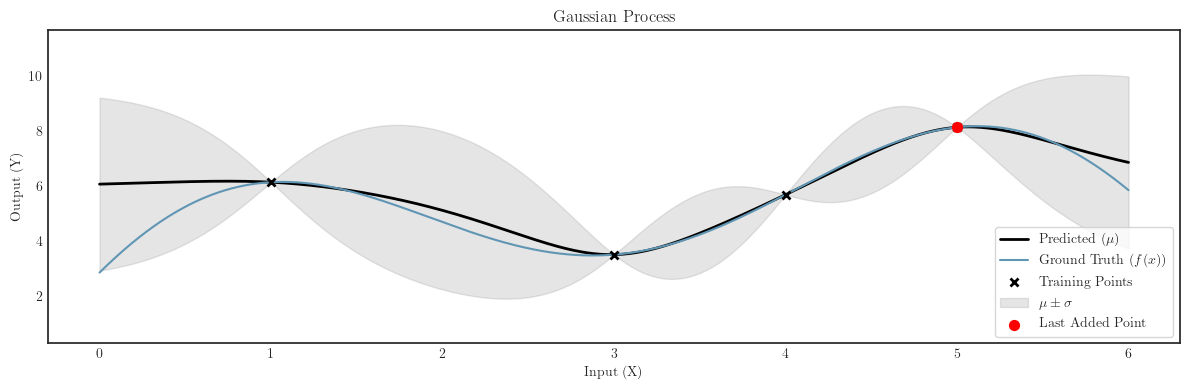

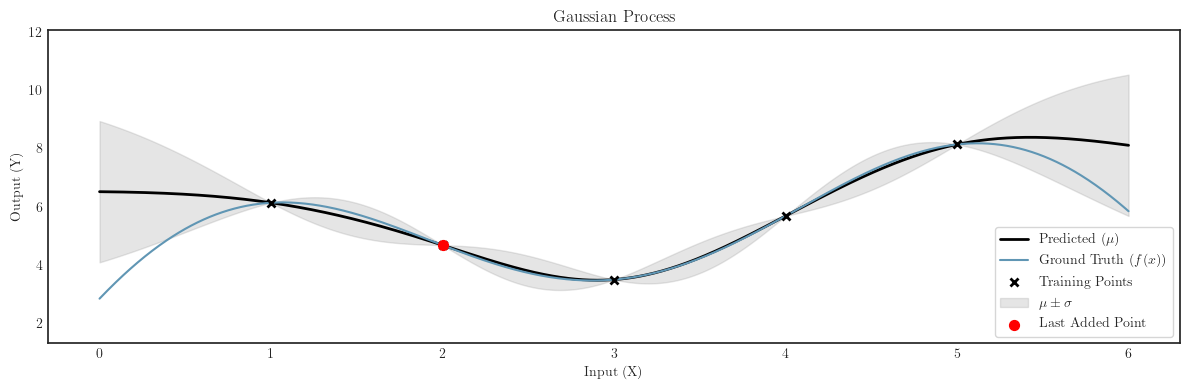

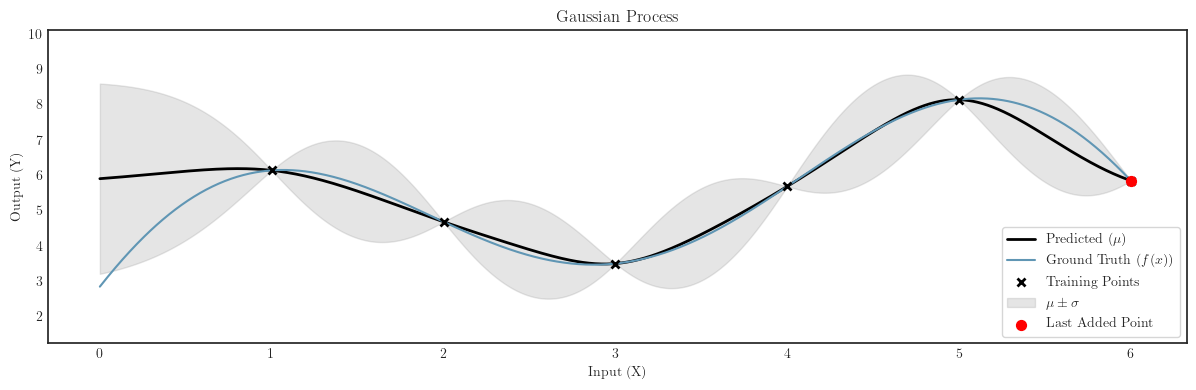

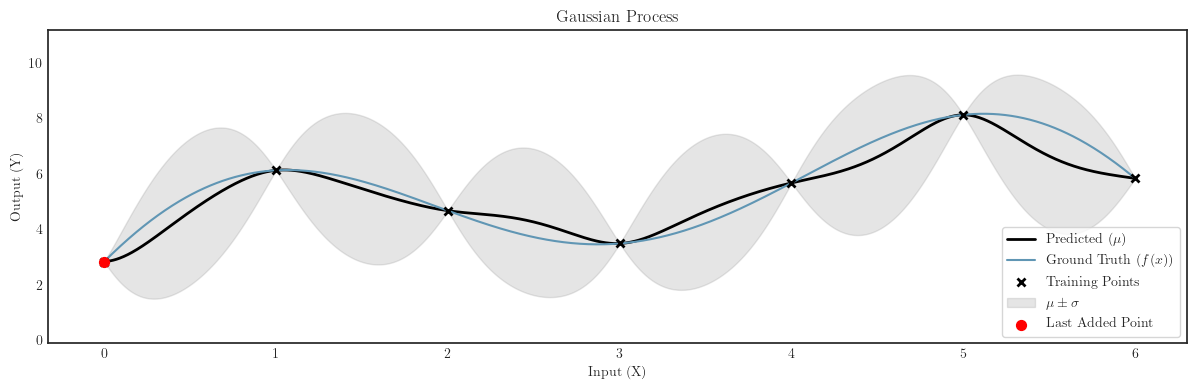

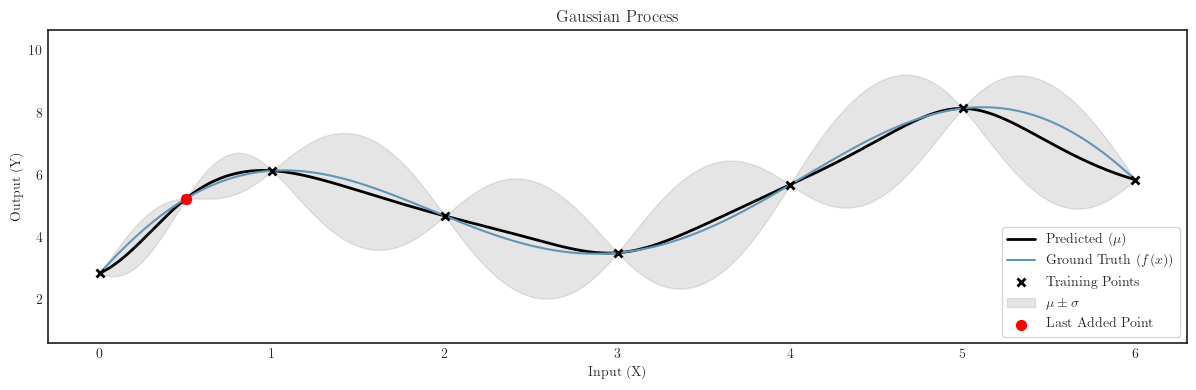

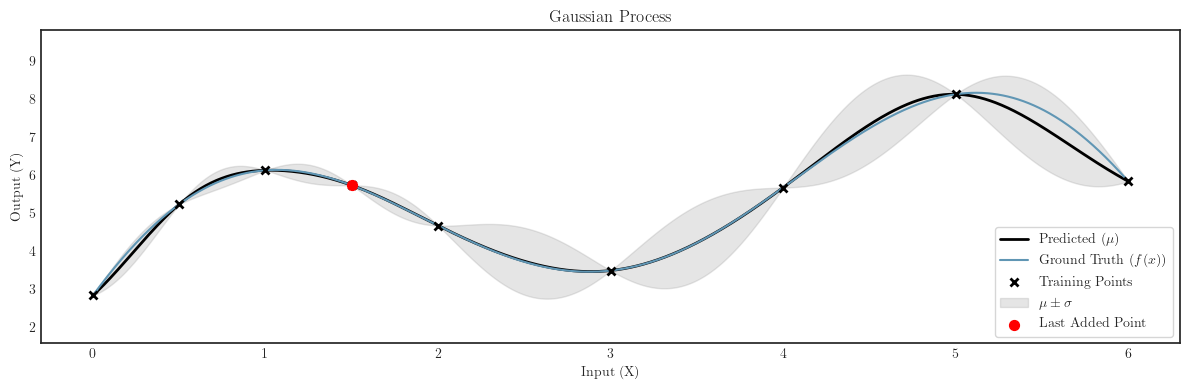

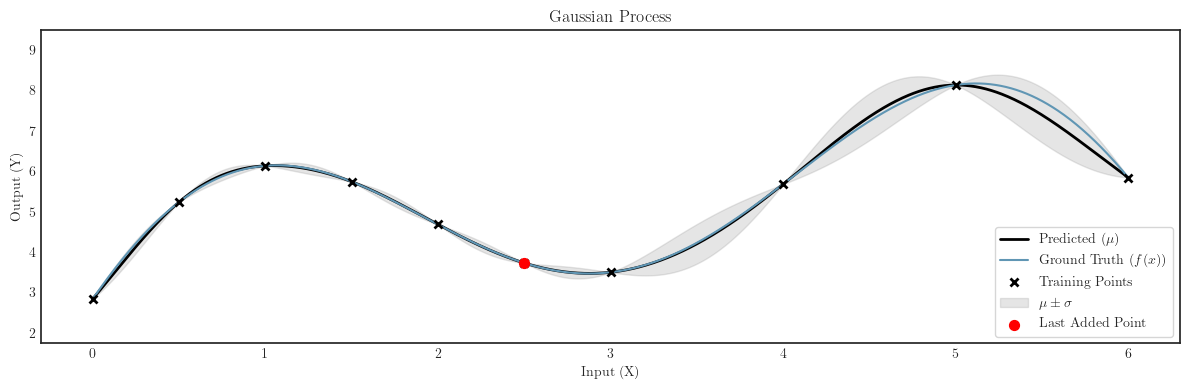

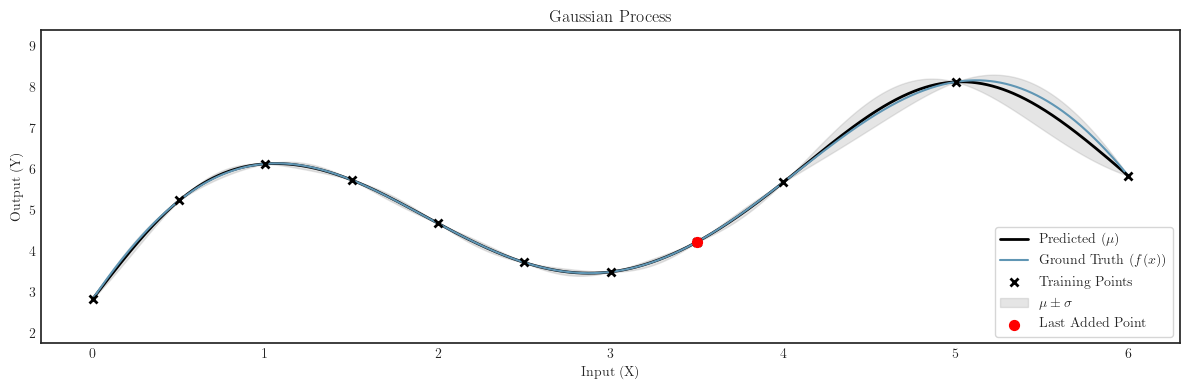

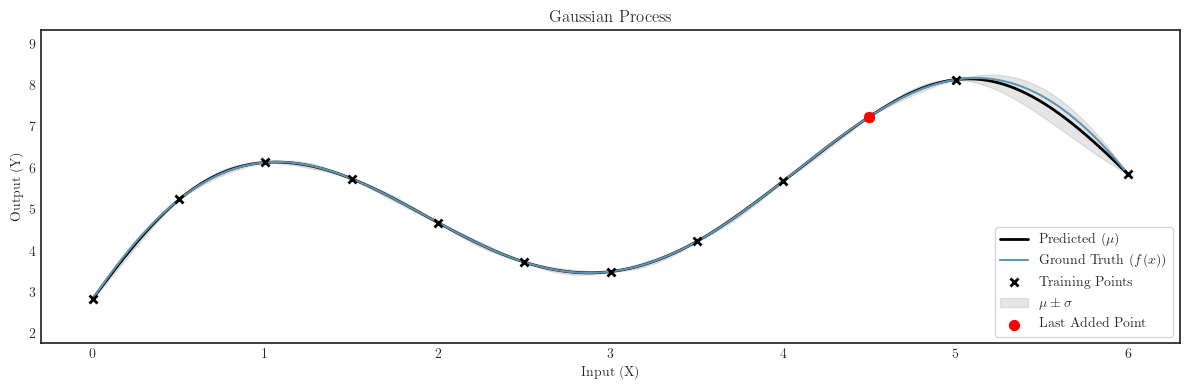

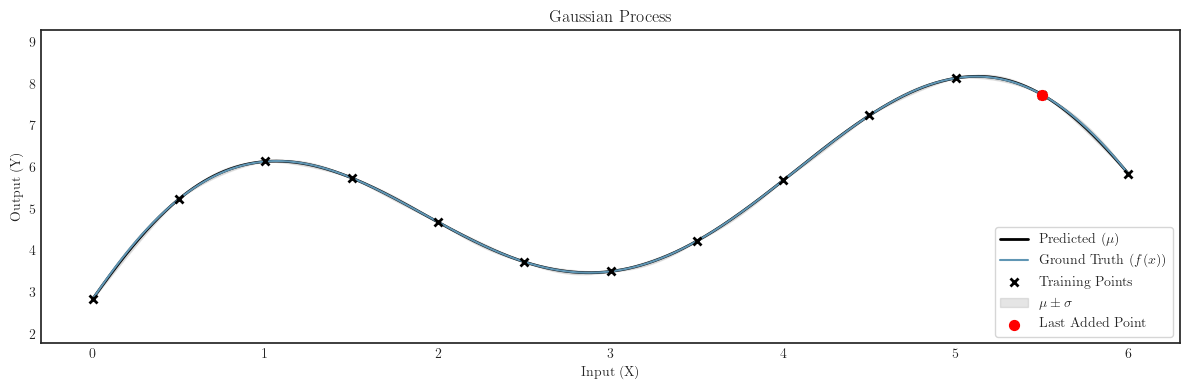

In [13]:
# Sample data
X = np.array([3, 4, 1, 5, 2, 6, 0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]).reshape(-1, 1)

# X_list will increase the number of points in each iteration
X_list = [X[:1], X[:2], X[:3], X[:4], X[:5], X[:6], X[:7], X[:8], X[:9], X[:10], X[:11], X[:12], X[:13]]

for X in X_list:
    Y = f(X)

    kernel = Matern52(input_dim=1, ARD=True, variance=1)
    mean_fn = Constant(1, 1, value=5)
    model = GPRegression(X, Y, kernel=kernel, noise_var=1e-8,
                        mean_function = mean_fn)

    # Optimize the model (find the best hyperparameters)
    model.optimize(messages=False)

    # Make predictions on a grid of points for plotting
    X_pred = np.linspace(0, 6, 1000).reshape(-1, 1)
    Y_pred, Y_var = model.predict(X_pred)
    Y_std = np.sqrt(Y_var)

    # Plot the results
    fig = plt.figure(figsize=(12, 4))
    plt.plot(X_pred, Y_pred, 'k-', lw=2, label=r'Predicted ($\mu$)')
    plt.fill_between(X_pred.flatten(), (Y_pred - 2*Y_std).flatten(), (Y_pred + 2*Y_std).flatten(), color='gray', alpha=0.2, label=r'$\mu \pm \sigma$')
    plt.plot(x_base, f(x_base), color="#6096B4", label=r'Ground Truth ($f(x)$)')
    plt.scatter(X[-1], Y[-1], color='red', s=50, zorder=5, label='Last Added Point')
    plt.plot(X, Y, 'kx', mew=2, label='Training Points')
    plt.legend(loc="lower right", fontsize=10, frameon=True, facecolor='white')
    plt.title('Gaussian Process')
    plt.xlabel('Input (X)')
    plt.ylabel('Output (Y)')
    plt.tight_layout()
    plt.margins(y=0.2)


    # Save the figure to a PDF (enable if needed)
    # pdf_file_path = 'gp_7.pdf'  # Change to your preferred file path
    # with PdfPages(pdf_file_path) as pdf:
    #     pdf.savefig(fig)
    # plt.close()

    # Show the plot
    plt.show()


# Example of simple Acquisition Function (EI) with Gaussian Process

It has one objective function and the acquisition function. The top graph represents the Gaussian Process of the function sin(x). The bottom plot illustrates the acquisition function, showcasing a peak, highlighted by an arrow, indicating the most promising new point to sample next. This point represents the trade-off between exploration and exploitation, where the next evaluation would yield the most valuable information.

 c:\Users\bhs-gs\AppData\Local\miniconda3\envs\python_3_gpss\lib\site-packages\matplotlib\patches.py:1038: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


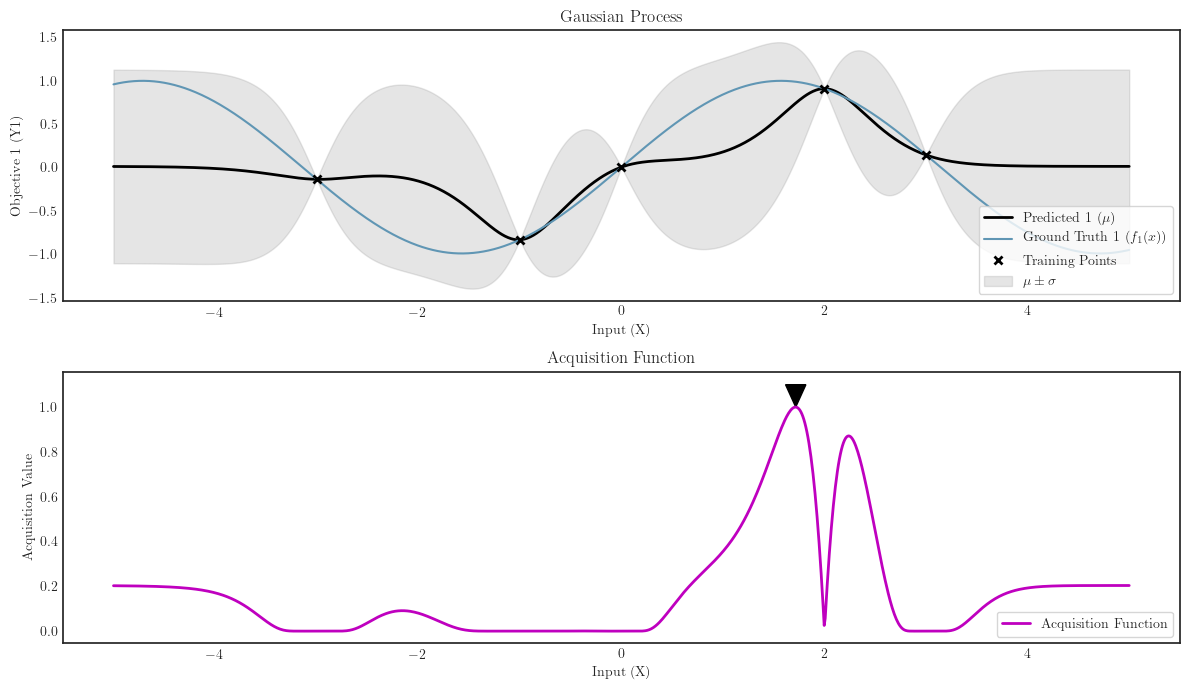

In [14]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
from scipy.stats import norm
from GPy.mappings.constant import Constant
from GPy.kern import Matern52
from GPy.models import GPRegression

# Objective function
def objective(x):
    return np.sin(x)

import numpy as np
import GPy
import matplotlib.pyplot as plt
from scipy.stats import norm

# Objective functions
def objective1(x):
    return np.sin(x)

def objective2(x):
    return np.cos(x)

def expected_improvement(X, X_sample, Y_sample, model, xi=0.1, mu_sample_opt=None):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process model.
    '''
    mu_sample, _ = model.predict(X_sample)
    mu, sigma = model.predict(X)
    sigma = sigma.reshape(-1, 1)

    sigma = np.sqrt(sigma)

    if mu_sample_opt is None:
        mu_sample_opt = np.max(model.predict(X_sample))

    mu_sample_opt = np.max(mu_sample)

    imp = mu - mu_sample_opt - xi
    with np.errstate(divide='warn'):
        # Safe division and handle close to zero sigma
        imp = mu - mu_sample_opt
        Z = np.divide(imp, sigma, out=np.zeros_like(sigma), where=sigma>1e-8)
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    # Normalize EI values for better visualization
    ei = ei / (np.max(ei) + 1e-9)

    return ei

# Sample data
X = np.array([0, 2, 3, -3, -1]).reshape(-1, 1)
Y1 = objective1(X) #+ np.random.randn(*X.shape)*0.05  # Objective 1

kernel1 = Matern52(input_dim=1, ARD=True, variance=1)
mean_fn1 = Constant(1, 1, value=5)
model1 = GPRegression(X, Y1, kernel=kernel1, noise_var=1e-8,
                    mean_function = mean_fn1)


# Optimize the models
model1.optimize(messages=False)

# Make predictions on a grid of points for plotting
X_pred = np.linspace(-5, 5, 1000).reshape(-1, 1)
Y_pred1, Y_var1 = model1.predict(X_pred)
Y_std1 = np.sqrt(Y_var1)

# Calculate the synthetic acquisition function
acq_values = expected_improvement(X_pred, X, Y1, model1)

# Plot the results for both objectives
fig = plt.figure(figsize=(12, 7))

# Plot Objective 1
plt.subplot(2, 1, 1)
plt.plot(X_pred, Y_pred1, 'k-', lw=2, label=r'Predicted 1 ($\mu$)')
plt.fill_between(X_pred.flatten(), (Y_pred1 - 2*Y_std1).flatten(), (Y_pred1 + 2*Y_std1).flatten(), color='gray', alpha=0.2, label=r'$\mu \pm \sigma$')
plt.plot(X_pred, objective1(X_pred), color="#6096B4", label=r'Ground Truth 1 ($f_1(x)$)')
plt.plot(X, Y1, 'kx', mew=2, label='Training Points')
plt.legend(loc="lower right", fontsize=10, frameon=True, facecolor='white')
plt.title('Gaussian Process')
plt.xlabel('Input (X)')
plt.ylabel('Objective 1 (Y1)')

# Plot Synthetic Acquisition Function
plt.subplot(2, 1, 2)

# Adding a triangle indicating peak of acquisition function
peak_x = X_pred[np.argmax(acq_values)]
peak_y = np.max(acq_values)
triangle = plt.Polygon([[peak_x - 0.1, peak_y + 0.1], [peak_x, peak_y], [peak_x + 0.1, peak_y + 0.1]], color='k')
plt.gca().add_patch(triangle)

plt.plot(X_pred, acq_values, 'm-', lw=2, label='Acquisition Function')
plt.legend(loc="lower right", fontsize=10, frameon=True, facecolor='white')
plt.title('Acquisition Function')
plt.xlabel('Input (X)')
plt.ylabel('Acquisition Value')
plt.tight_layout()

# Save the figure to a PDF (enable if needed)
# pdf_file_path = 'aqf_gp_1obj_example.pdf'
# with PdfPages(pdf_file_path) as pdf:
#     pdf.savefig(fig)

plt.show()



# Example of multiobjective Acquisition Function (EHVI) and Gaussian Process

After three observations from a multi-objective problem, two posterior beliefs are leveraged to calculate the EHVI, quantifying the potential benefit of new observations to the Pareto Front. The peak of the EHVI curve indicates the most promising location for the next observation.

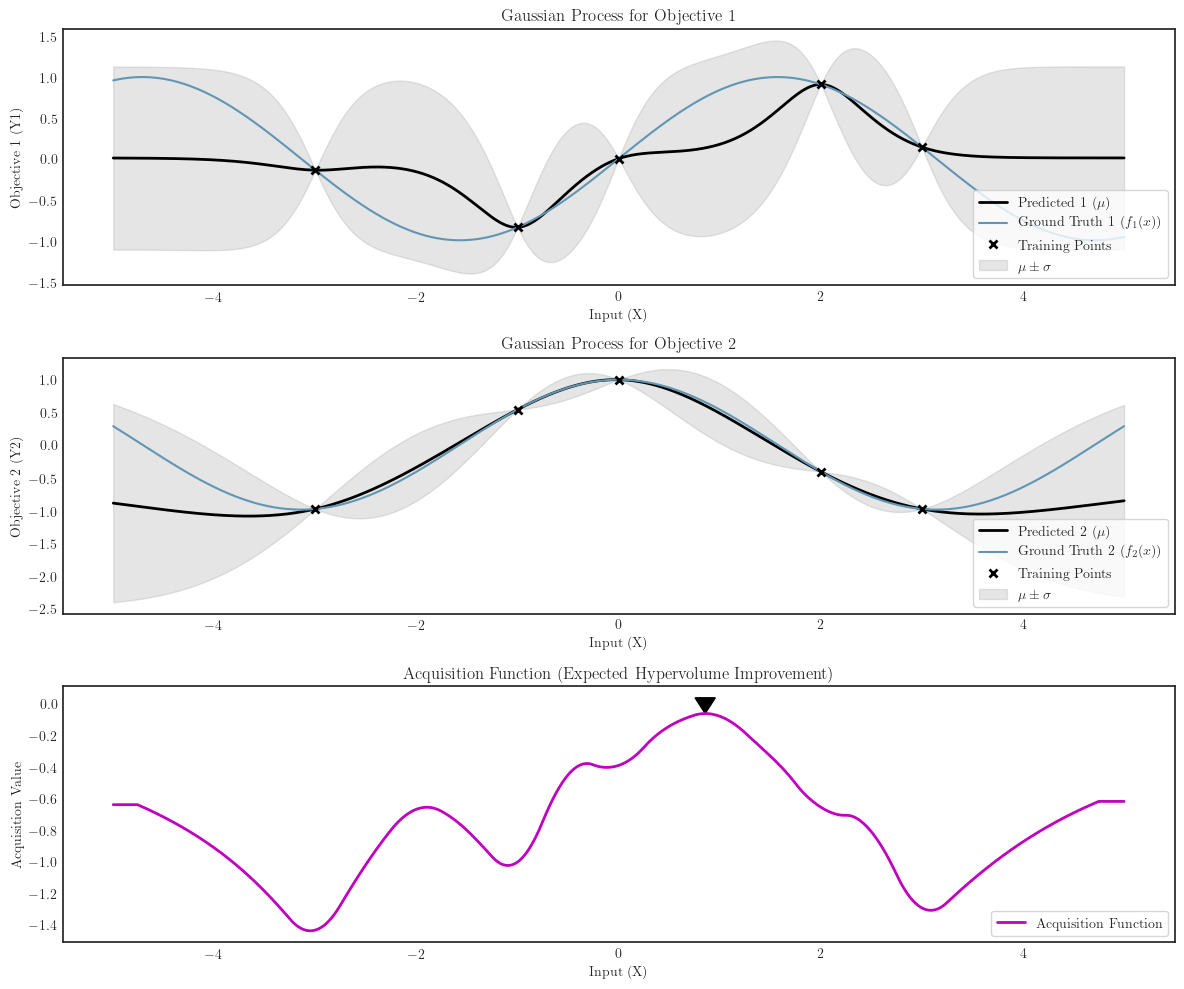

In [15]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
from scipy.signal import _savitzky_golay as savitzky_golay

# Objective functions
def objective1(x):
    return np.sin(x)

def objective2(x):
    return np.cos(x)

def simple_moving_average(data, window_size):
    """Applies simple moving average with a defined window size."""
    sma = np.convolve(data.flatten(), np.ones(window_size)/window_size, mode='valid')
    # Padding to match original length
    pad_len = (len(data) - len(sma)) // 2
    sma_padded = np.pad(sma, (pad_len, len(data) - len(sma) - pad_len), 'edge')
    return sma_padded

def calculate_distance_penalty(X_pred, X_sampled, penalty_scale):
    # Calculate the distance from each point in X_pred to the nearest point in X_sampled
    distances = np.min(np.abs(X_pred[:, None] - X_sampled[None, :]), axis=1)
    # Apply a penalty based on the distance
    penalty = np.exp(-penalty_scale * distances)
    return penalty

def penalized_synthetic_acquisition(X_pred, X_sampled, model1, model2, weight1=0.5, weight2=0.5, penalty_scale=1.0):
    Y_pred1, Y_var1 = model1.predict(X_pred)
    Y_pred2, Y_var2 = model2.predict(X_pred)
    # Basic acquisition values
    acquisition_values = weight1 * Y_pred1 + weight2 * Y_pred2
    # Calculate the distance penalty
    penalties = calculate_distance_penalty(X_pred, X_sampled, penalty_scale)
    # Apply penalties
    acquisition_values -= penalties
    return simple_moving_average(acquisition_values, 50)

# Sample data
X = np.array([0, 2, 3, -3, -1]).reshape(-1, 1)
Y1 = objective1(X)
Y2 = objective2(X)

kernel1 = Matern52(input_dim=1, ARD=True, variance=1)
mean_fn1 = Constant(1, 1, value=5)
model1 = GPRegression(X, Y1, kernel=kernel1, noise_var=1e-8,
                    mean_function = mean_fn1)

kernel2 = Matern52(input_dim=1, ARD=True, variance=1)
mean_fn2 = Constant(1, 1, value=5)
model2 = GPRegression(X, Y2, kernel=kernel2, noise_var=1e-8,
                    mean_function = mean_fn2)

# Optimize the models
model1.optimize(messages=False)
model2.optimize(messages=False)

# Make predictions on a grid of points for plotting
X_pred = np.linspace(-5, 5, 1000).reshape(-1, 1)
Y_pred1, Y_var1 = model1.predict(X_pred)
Y_std1 = np.sqrt(Y_var1)
Y_pred2, Y_var2 = model2.predict(X_pred)
Y_std2 = np.sqrt(Y_var2)

# Calculate the synthetic acquisition function
acq_values = penalized_synthetic_acquisition(X_pred, X, model1, model2)

# Plot the results for both objectives
fig = plt.figure(figsize=(12, 10))

# Plot Objective 1
plt.subplot(3, 1, 1)
plt.plot(X_pred, Y_pred1, 'k-', lw=2, label=r'Predicted 1 ($\mu$)')
plt.fill_between(X_pred.flatten(), (Y_pred1 - 2*Y_std1).flatten(), (Y_pred1 + 2*Y_std1).flatten(), color='gray', alpha=0.2, label=r'$\mu \pm \sigma$')
plt.plot(X_pred, objective1(X_pred), color="#6096B4", label=r'Ground Truth 1 ($f_1(x)$)')
plt.plot(X, Y1, 'kx', mew=2, label='Training Points')
plt.legend(loc="lower right", fontsize=10, frameon=True, facecolor='white')
plt.title('Gaussian Process for Objective 1')
plt.xlabel('Input (X)')
plt.ylabel('Objective 1 (Y1)')

# Plot Objective 2
plt.subplot(3, 1, 2)
plt.plot(X_pred, Y_pred2, 'k-', lw=2, label=r'Predicted 2 ($\mu$)')
plt.fill_between(X_pred.flatten(), (Y_pred2 - 2*Y_std2).flatten(), (Y_pred2 + 2*Y_std2).flatten(), color='gray', alpha=0.2, label=r'$\mu \pm \sigma$')
plt.plot(X_pred, objective2(X_pred), color="#6096B4", label=r'Ground Truth 2 ($f_2(x)$)')
plt.plot(X, Y2, 'kx', mew=2, label='Training Points')
plt.legend(loc="lower right", fontsize=10, frameon=True, facecolor='white')
plt.title('Gaussian Process for Objective 2')
plt.xlabel('Input (X)')
plt.ylabel('Objective 2 (Y2)')

# Plot Synthetic Acquisition Function
plt.subplot(3, 1, 3)

# Adding a triangle indicating peak of acquisition function
peak_x = X_pred[np.argmax(acq_values)]
peak_y = np.max(acq_values)
triangle = plt.Polygon([[peak_x - 0.1, peak_y + 0.1], [peak_x, peak_y], [peak_x + 0.1, peak_y + 0.1]], color='k')
plt.gca().add_patch(triangle)

plt.plot(X_pred, acq_values, 'm-', lw=2, label='Acquisition Function')
plt.legend(loc="lower right", fontsize=10, frameon=True, facecolor='white')
plt.title('Acquisition Function (Expected Hypervolume Improvement)')
plt.xlabel('Input (X)')
plt.ylabel('Acquisition Value')
plt.tight_layout()

# Save the figure to a PDF (enable if needed)
# pdf_file_path = 'aqf_gp_example.pdf'
# with PdfPages(pdf_file_path) as pdf:
#     pdf.savefig(fig)

plt.show()
